In [2]:
import tensorflow as tf
 
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.001, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon  # 用于避免除以零的小常数
    
    def build(self, input_shape):
        self.alpha = self.add_weight(
            name='alpha',
            shape=input_shape[-1:],
            initializer='ones', 
            trainable=True,
            dtype=tf.float32
        )
        
        self.beta = self.add_weight(
            name='beta',
            shape=input_shape[-1:],
            initializer='zeros', 
            trainable=True,
            dtype=tf.float32
        )
        super().build(input_shape)
    
    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        output = self.alpha * normalized + self.beta
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({'epsilon': self.epsilon})
        return config


In [3]:
import numpy as np

inputs = np.random.randn(32, 10).astype(np.float32)

custom_layer = LayerNormalization()
custom_output = custom_layer(inputs)

keras_layer = tf.keras.layers.LayerNormalization()
keras_output = keras_layer(inputs)

print("allclose:", np.allclose(custom_output.numpy(), keras_output.numpy()))

allclose: False


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow import keras as ks
 
# 1. 加载Fashion MNIST数据集
(x_train, y_train), (x_test, y_test) = ks.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1).astype('float32') / 255.0 
x_test = x_test.reshape(x_test.shape[0],-1).astype('float32') / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [8]:
class MNIST_train_model(ks.Model):
    def __init__(self, class_num = 10, num_layers = 5, **kwargs):
        super().__init__(**kwargs)
        self.class_num = class_num
        self.num_layers = num_layers
        self.model_layers = ks.models.Sequential(
            [ks.layers.Dense(32, activation=ks.activations.gelu) for _ in range(num_layers)]+
            [ks.layers.Dense(class_num, activation='softmax'),
            ks.layers.Dense(class_num)
        ]) 
    
    def bulid(self, input_shape):
        super().build(input_shape)
    
    def call(self, inputs):
        out = self.model_layers(inputs)
        return out

model = MNIST_train_model()


Epoch 1/10
Train Loss: 0.17046, Train Acc: 94.35625%, Val Loss: 0.50451, Val Acc: 86.43333%

Epoch 2/10
Train Loss: 0.17060, Train Acc: 94.28125%, Val Loss: 0.51674, Val Acc: 86.03333%

Epoch 3/10
Train Loss: 0.17507, Train Acc: 94.15833%, Val Loss: 0.51835, Val Acc: 86.32500%

Epoch 4/10
Train Loss: 0.16916, Train Acc: 94.31875%, Val Loss: 0.54342, Val Acc: 85.88333%

Epoch 5/10
Train Loss: 0.18866, Train Acc: 93.74375%, Val Loss: 0.50308, Val Acc: 86.50833%

Epoch 6/10
Train Loss: 0.16708, Train Acc: 94.34792%, Val Loss: 0.52782, Val Acc: 86.26667%

Epoch 7/10
Train Loss: 0.17117, Train Acc: 94.30208%, Val Loss: 0.50969, Val Acc: 86.70833%

Epoch 8/10
Train Loss: 0.16489, Train Acc: 94.53958%, Val Loss: 0.50624, Val Acc: 86.68333%

Epoch 9/10
Train Loss: 0.15944, Train Acc: 94.65417%, Val Loss: 0.50340, Val Acc: 86.87500%

Epoch 10/10
Train Loss: 0.16515, Train Acc: 94.54584%, Val Loss: 0.52527, Val Acc: 86.19167%


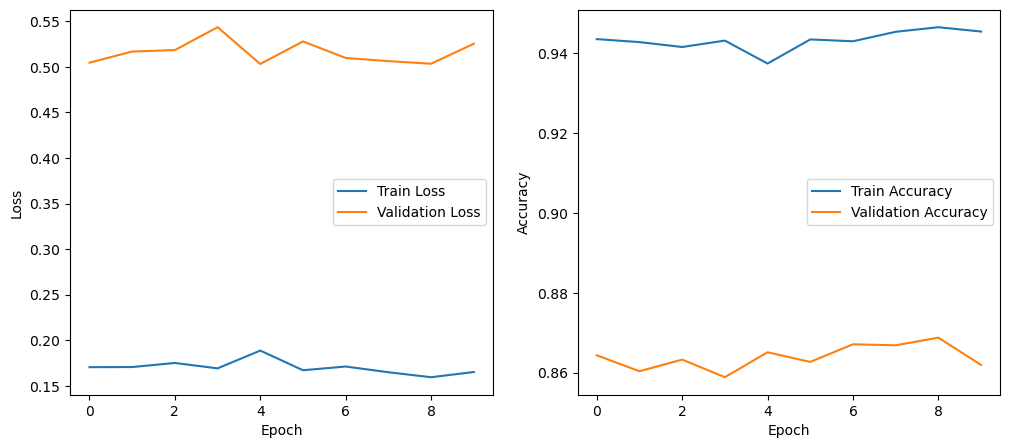

Test Loss: 0.54438, Test Accuracy: 85.83000%


In [18]:
from matplotlib import pyplot as plt

model.bulid(input_shape=(None, x_train.shape[1]))
 
optimizer_features = ks.optimizers.Adam(learning_rate=0.001)

def evaluate_model(model, dataset):
    loss_func = ks.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x_batch, y_batch in dataset:
        logits = model(x_batch, training=False)
        loss_value = loss_func(y_batch, logits)

        loss_avg.update_state(loss_value)
        accuracy.update_state(y_batch, logits)

    return loss_avg.result().numpy(), accuracy.result().numpy()
    
def train_model(model, train_dataset, val_dataset, num_epochs=10, patience=3, early_stop=True, early_stop_value=0.001):
    loss_func = ks.losses.SparseCategoricalCrossentropy(from_logits=True)
    feature_vars = model.model_layers.trainable_variables
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as features_tape:

                logits = model(x_batch_train, training=True)
                loss_value = loss_func(y_batch_train, logits)
            
            # 计算梯度
            features_grads = features_tape.gradient(loss_value, feature_vars)
            
            # 分别应用梯度
            optimizer_features.apply_gradients(zip(features_grads, feature_vars))
            
            # 更新指标
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y_batch_train, logits)
        
        # 记录训练结束时的指标
        train_loss = epoch_loss_avg.result().numpy()
        train_acc = epoch_accuracy.result().numpy()
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        val_loss, val_acc = evaluate_model(model, val_dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f'Train Loss: {train_loss:.5f}, Train Acc: {train_acc*100:.5f}%, '
              f'Val Loss: {val_loss:.5f}, Val Acc: {val_acc*100:.5f}%')
        if early_stop:
            count = 0
            max_val_acc = 0
            if val_acc > max_val_acc:
                max_val_acc = val_acc
            if val_acc - max_val_acc < early_stop_value:
                count += 1
            else:
                count = 0
            if count >= patience:
                return train_loss_history, train_acc_history, val_loss_history, val_acc_history

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history
 
num_epochs = 10
train_loss, train_acc, val_loss, val_acc = train_model(model, train_dataset, val_dataset, num_epochs)
 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
 
test_loss, test_acc = evaluate_model(model, test_dataset)
print(f'Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc*100:.5f}%')